# MNIST Dataset Example <a name="MNIST-Dataset-Example-mnist"></a>
This example extends the scikit-learn notebook found in the base ``xaitk-saliency`` repo [here](https://github.com/XAITK/xaitk-saliency/blob/master/examples/MNIST_scikit_saliency.ipynb), and explores integrating ``xaitk-saliency`` with ``MLFlow`` to track model metrics and saliency maps.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/xaitk-jatic/blob/main/docs/examples/jmlflow/MNIST_MLFlow_scikit_saliency.ipynb)

## Environment Setup <a name="environment-setup"></a>

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/Kitware/xaitk-jatic/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).

In [1]:
import sys  # noqa:F401

!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency
!{sys.executable} -m pip install -q mlflow
!{sys.executable} -m pip install -q matplotlib

## Downloading the Dataset <a name="Download-the-Dataset-mnist"></a>

The MNIST dataset consists of 70,000 28x28 grayscale images of handwritten numbers.
Each image is stored as a column vector, resulting in a (70000,784) shape for the entire dataset.

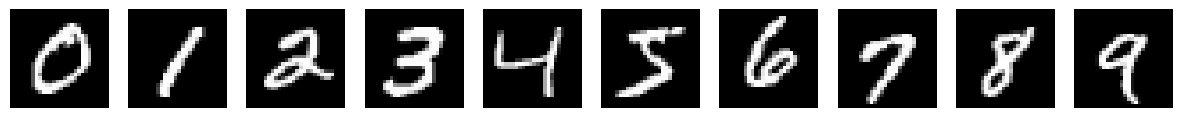

In [ ]:
import os
from collections.abc import Iterable, Iterator
from typing import Any, Optional

import matplotlib.pyplot as plt  # type:ignore
import numpy as np
from matplotlib.figure import FigureBase
from sklearn.datasets import fetch_openml
from typing_extensions import override

cwd = os.getcwd()
data_dir = cwd + "/data/scikit-learn-example"

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, data_home=data_dir)
X = X / X.max()

# Find examples of each class
ref_inds = [np.where(np.int64(y) == i)[0][0] for i in range(10)]

ref_imgs = X[ref_inds]

# Plot examples
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(ref_imgs[i].reshape(28, 28), "gray")
    plt.axis("off")

# MLP Example <a name="MLP-Example-mnist"></a>
## Fitting the Model <a name="Fitting-the-Model-mlp-mnist"></a>

Following the second [example](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html#sphx-glr-auto-examples-neural-networks-plot-mnist-filters-py) from scikit-learn, we train an `MLPClassifier` on the MNIST dataset using the same hyperparameters.

To shorten training time, the MLP has only one hidden layer with 50 nodes, and is only trained for 10 iterations, meaning the model does not entirely converge.

In [2]:
import warnings

import matplotlib.pyplot as plt  # type: ignore
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier

# use the traditional train/test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

params = {
    "hidden_layer_sizes": (50,),
    "max_iter": 10,
    "alpha": 1e-4,
    "solver": "sgd",
    "verbose": 10,
    "random_state": 1,
    "learning_rate_init": 0.1,
}

mlp = MLPClassifier(**params)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    x = mlp.fit(X_train, y_train)

Iteration 1, loss = 0.32009978
Iteration 2, loss = 0.15347534
Iteration 3, loss = 0.11544755
Iteration 4, loss = 0.09279764
Iteration 5, loss = 0.07889367
Iteration 6, loss = 0.07170497
Iteration 7, loss = 0.06282111
Iteration 8, loss = 0.05530788
Iteration 9, loss = 0.04960484
Iteration 10, loss = 0.04645355


## Black-Box Classifier <a name="Black-Box-Classifier-mlp-mnist"/></a>

We wrap our `MLPClassifier` object in [SMQTK-Classifier's](https://smqtk-classifier.readthedocs.io/en/stable/classifier_interfaces.html#classifyimage) `ClassifyImage` class to comply with the API's interface.

In [3]:
from smqtk_classifier.interfaces.classify_image import ClassifyImage


class MNISTClassifierMLP(ClassifyImage):
    """
    A class for classifying MNIST images using a trained Multi-Layer Perceptron (MLP) model.

    Inherits:
        ClassifyImage: Base class for image classification tasks.

    Methods:
        get_labels() -> List[int]:
            Returns the list of class labels (0-9 for MNIST).

        classify_images(img_iter: Iterator[np.ndarray]) -> Iterator[Dict[int, float]]:
            Classifies a batch of images and returns predicted probabilities for each class.

        get_config() -> Dict[str, Any]:
            Returns the configuration of the classifier (placeholder for this implementation).
    """

    @override
    def get_labels(self) -> list[int]:
        return list(range(10))

    @override
    def classify_images(self, img_iter: Iterable[np.ndarray]) -> Iterator[dict[int, float]]:
        # Yes, "images" in this example case are really 1-dim (28*28=784).
        # MLP input needs a (n_samples, n_features) matrix input.
        images = np.asarray(list(img_iter))  # may fail because input is not consistent in shape
        images = images.reshape(-1, 28 * 28)  # may fail because input was not the correct shape
        for pred in mlp.predict_proba(images):
            to_yield = dict()
            for i, p in zip(range(10), pred):
                to_yield[i] = float(p)
            yield to_yield

    # Required for implementation
    @override
    def get_config(self) -> dict[str, Any]:
        return {}


image_classifier_mlp = MNISTClassifierMLP()

## The "Application" <a name="The-Application-mnist"></a>

Our "application" will accept a set of images, a black-box image classifier, and a saliency generator and will generate saliency maps for each image provided.
The saliency maps from the first image in the set will then be plotted to give an idea of the model's behavior on a single sample.

Additionally, because all digits in the MNIST dataset are centered in the frame, we can average all the heatmaps generated for each respective class to produce a decision boundary visualization.
The application will do this and plot the resulting averaged heatmaps for each digit class.

In [4]:
from xaitk_saliency.interfaces.gen_image_classifier_blackbox_sal import GenerateImageClassifierBlackboxSaliency


def app(
    images: np.ndarray,
    image_classifier: ClassifyImage,
    saliency_generator: GenerateImageClassifierBlackboxSaliency,
) -> tuple[FigureBase, FigureBase, list[np.ndarray]]:
    """
    Generates saliency maps for a set of images, visualizes the saliency maps for the first image,
    and computes and visualizes the average saliency maps across all images.

    Args:
        images (np.ndarray): A numpy array of input images, where each image is
        flattened (e.g., shape (num_images, 784)).
        image_classifier (ClassifyImage): An object representing the trained image classifier.
        saliency_generator (GenerateImageClassifierBlackboxSaliency):
            A callable that generates saliency maps for an input image and classifier.

    Returns:
        Tuple[plt.Figure, plt.Figure, List[np.ndarray]]:
            - `plt.Figure`: A figure displaying saliency maps for the first image in the input set.
            - `plt.Figure`: A figure displaying average saliency maps across all input images.
            - `List[np.ndarray]`: A list of numpy arrays containing saliency maps for each input image.

    Raises:
        ValueError: If the saliency maps' shape does not match the expected dimensions.
    """
    # Generate saliency maps
    sal_maps_set = []
    for img in images:
        ref_image = img.reshape(28, 28)
        sal_maps = saliency_generator(ref_image, image_classifier)
        sal_maps_set.append(sal_maps)

    num_classes = sal_maps_set[0].shape[0]

    # Plot first image in set with saliency maps
    fig_1 = plt.figure(figsize=(10, 5))
    plt.suptitle("Heatmaps for First Image", fontsize=16)
    num_cols = np.ceil(num_classes / 2).astype(int) + 1
    plt.subplot(2, num_cols, 1)
    plt.imshow(images[0].reshape(28, 28), cmap="gray")
    plt.xticks(())
    plt.yticks(())

    for c in range(num_cols - 1):
        plt.subplot(2, num_cols, c + 2)
        plt.imshow(sal_maps_set[0][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(f"Class {c}")
    for c in range(num_classes - num_cols + 1, num_classes):
        plt.subplot(2, num_cols, c + 3)
        plt.imshow(sal_maps_set[0][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(f"Class {c}")

    # Average heatmaps for each respective class
    global_maps = np.sum(sal_maps_set, axis=0) / len(images)

    # Plot average maps
    fig_2 = plt.figure(figsize=(10, 5))
    plt.suptitle("Average Heatmaps from All Images", fontsize=16)
    for c in range(num_classes):
        v_cap = np.absolute(global_maps[c]).max()
        plt.subplot(2, num_cols - 1, c + 1)
        plt.imshow(global_maps[c], cmap=plt.cm.RdBu, vmin=-v_cap, vmax=v_cap)  # type: ignore
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(f"Class {c}")
    return fig_1, fig_2, sal_maps_set

## Heatmap Generation <a name="Heatmap-Generation-mnist"></a>

We create an instance of `SlidingWindowStack`, an implementation of the `GenerateImageClassifierBlackboxSaliency` interface, to carry out our image perturbation and heatmap generation.

In [5]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack

gen_sliding_window = SlidingWindowStack(window_size=(2, 2), stride=(1, 1), threads=4)

## Calling the Application <a name="Calling-the-Application-mlp-mnist"></a>

We call our application using a small MNIST image subset, our saliency generator, and our MLP classifier.

The results show mostly negative saliency, suggesting that the MLP model has learned where the pixels are *absent* for each class more than where they are *present*.

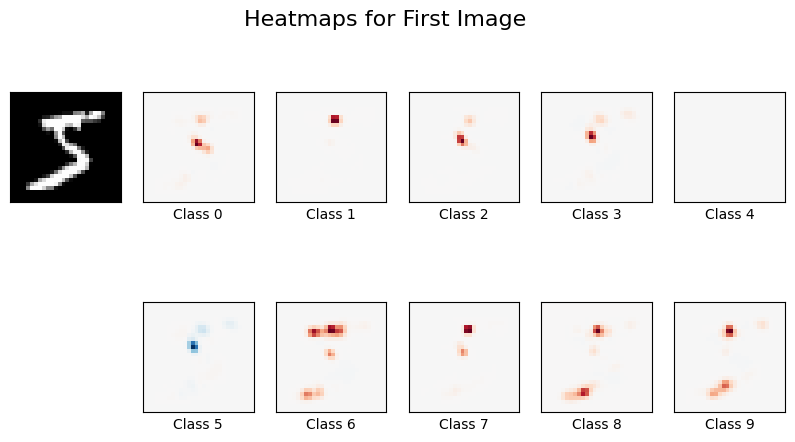

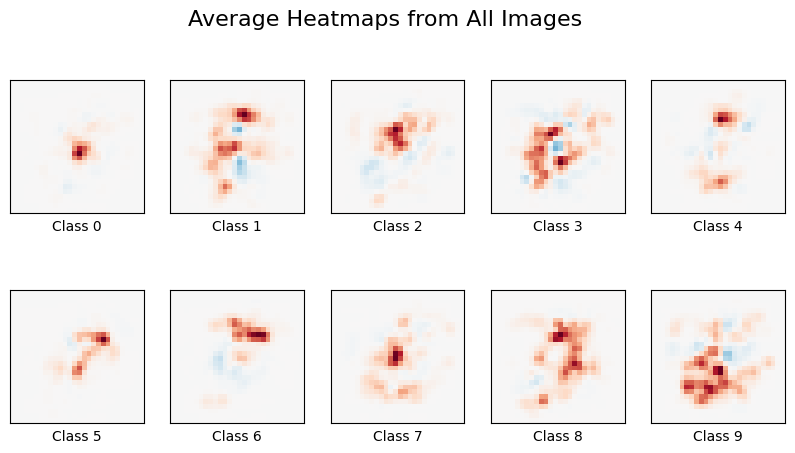

In [6]:
fig_1, fig_2, sal_maps = app(X[0:20], image_classifier_mlp, gen_sliding_window)

## Generating Saliency maps for a specific image <a name="Generate-Saliency-mlp-mnist"></a>

The `app` function from [The Application](#the-application) section is modified to generate class-wise saliency maps for a specific `image_id`.

In [7]:
import matplotlib.pyplot as plt  # type: ignore
from smqtk_classifier.interfaces.classify_image import ClassifyImage
from xaitk_saliency.interfaces.gen_image_classifier_blackbox_sal import GenerateImageClassifierBlackboxSaliency


class GenerateSaliency:
    """
    A class to generate and visualize saliency maps for an input image using a provided classifier
    and saliency generator.
    """

    def gen_saliency_maps(
        self,
        image_id: int,
        img: np.ndarray,
        image_classifier: ClassifyImage,
        saliency_generator: GenerateImageClassifierBlackboxSaliency,
    ) -> tuple[FigureBase, np.ndarray]:
        """
        Generates and visualizes saliency maps for a given image.

        Args:
            image_id (int): The ID of the image for which saliency maps are generated.
            img (np.ndarray): The input image as a flattened numpy array (e.g., shape (784,)).
            image_classifier (ClassifyImage): An object representing the trained image classifier.
            saliency_generator (GenerateImageClassifierBlackboxSaliency):
                A callable that generates saliency maps for the input image and classifier.

        Returns:
            Tuple[plt.Figure, np.ndarray]:
                - `plt.Figure`: The figure containing the visualized saliency maps.
                - `np.ndarray`: A numpy array of the generated saliency maps, where each slice corresponds
                  to a different class.

        Raises:
            ValueError: If the saliency maps' shape is inconsistent with the expected number of classes.
        """
        # Generate saliency maps
        ref_image = img.reshape(28, 28)
        sal_maps = saliency_generator(ref_image, image_classifier)

        num_classes = sal_maps.shape[0]

        # Plot nth image in set with saliency maps
        fig_1 = plt.figure(figsize=(10, 5))
        plt.suptitle(f"Saliency Maps for Image_ID: {str(image_id)}", fontsize=16)
        num_cols = np.ceil(num_classes / 2).astype(int) + 1
        plt.subplot(2, num_cols, 1)
        plt.imshow(img.reshape(28, 28), cmap="gray")
        plt.xticks(())
        plt.yticks(())

        for c in range(num_cols - 1):
            plt.subplot(2, num_cols, c + 2)
            plt.imshow(sal_maps[c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
            plt.xticks(())
            plt.yticks(())
            plt.xlabel(f"Class {c}")
        for c in range(num_classes - num_cols + 1, num_classes):
            plt.subplot(2, num_cols, c + 3)
            plt.imshow(sal_maps[c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
            plt.xticks(())
            plt.yticks(())
            plt.xlabel(f"Class {c}")

        return fig_1, sal_maps

# MLFlow: Run-based Workflow <a name="MLFlow-mlp-mnist"></a>

We implement an end-to-end pipeline example using MLFlow's `Experiment` and `Run` capabilities. Each experiment represents each stage of the pipeline as follows:
- &lt;Algorithm name&gt; - `Train`
- &lt;Algorithm name&gt; - `Evaluation`
- &lt;Algorithm name&gt; - `Saliency Map Generation`

We are using the MLP example here and so we set the &lt;Algorithm name&gt; to `MLPClassifier`.

Under each experiment, the information logging happens in the form of MLFlow runs. Finally, each run opens up a dashboard with 4 main information subsections:
- `Parameters` - Specifically used in the `Train` stage to store model parameters.
- `Metrics` - Different metrics are stored across different stages and are used, most importantly, in querying specific runs based on a given threshold value.
- `Tags` - Key-value pair entries containing information that is useful for querying and also to link runs across different stages of the pipeline.
- `Artifacts` - Used for storing saliency map images, numpy arrays, model metadata, etc.

## Instructions before running the MLFlow pipeline <a name="MLFlowInstructions-mlp-mnist"></a>
Before running the cells below, make sure to open a terminal, (activate your python venv if you are using one) and run the following commands:

> `cd "/working/directory/of/current/notebook"`
>
> `mlflow ui`

or execute the cell below to run as a python subprocess

In [8]:
import shutil
import subprocess

# Validate that the "mlflow" executable exists in the system PATH
mlflow_path = shutil.which("mlflow")
if mlflow_path is None:
    raise FileNotFoundError(
        "The 'mlflow' command was not found in your PATH.\
                            Please ensure MLflow is installed and accessible.",
    )

# Use the full path to the mlflow executable and validate inputs
try:
    # Use the full path to the mlflow executable
    command = [mlflow_path, "ui"]

    # Launch MLflow UI using subprocess
    p = subprocess.Popen(  # noqa:S603
        command,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,  # Ensures output is decoded into strings
    )

    print(f"MLflow UI started with PID {p.pid}. Access it at http://127.0.0.1:5000")

except FileNotFoundError as fnf_error:
    # Handle cases where subprocess fails due to missing executable
    raise FileNotFoundError(
        "The specified 'mlflow' executable was not found.\
                            Ensure MLflow is installed.",
    ) from fnf_error

except subprocess.SubprocessError as sp_error:
    # Handle subprocess-specific errors
    raise RuntimeError("An error occurred while starting the MLflow UI process.") from sp_error

MLflow UI started with PID 143527. Access it at http://127.0.0.1:5000


## MLFlowXAI - Initialize MLFlow experiment <a name="MLFlowXAI-mlp-mnist"></a>

The `MLFlowXAI` class initalizes the variables and methods required for creating a new MLFlow experiment or retrieving an existing experiment with the same name.

In [ ]:
import mlflow  # type: ignore
from mlflow import MlflowClient  # type: ignore
from mlflow.entities import Experiment, ViewType  # type: ignore


class MLFlowXAI:
    """
    A base class for managing MLflow experiments and configurations in Explainable AI workflows.

    Attributes:
        mlruns_path (str): Path to the MLflow runs directory.
        framework (str): Framework used (e.g., "sklearn").
        version (str): Version identifier for the experiment setup.
        dataset (str): Dataset name used in the experiment (default is "MNIST").
        datasplit (str): Data split identifier (default is "test").
        client (MlflowClient): An instance of MlflowClient for MLflow operations.
    """

    def __init__(self) -> None:
        """
        Initializes the MLFlowXAI class with default configurations for MLflow.

        Attributes like `mlruns_path`, `framework`, `version`, `dataset`, and `datasplit`
        are set with default values, and the MLflow client is initialized to None.
        """
        self.mlruns_path = "./mlruns"
        self.framework = "sklearn"
        self.version = "v1"
        self.dataset = "MNIST"
        self.datasplit = "test"
        self.client = None

    def init_experiment(self, experiment_name: str) -> Experiment:
        """
        Initializes an MLflow experiment by creating or retrieving it based on the provided name.

        Args:
            experiment_name (str): The name of the MLflow experiment to initialize.

        Returns:
            Experiment: The initialized MLflow experiment object.

        Raises:
            OSError: If there is an issue creating the directory for MLflow runs.
        """
        self.client = MlflowClient()
        client = self.client

        if not os.path.exists(self.mlruns_path):
            os.makedirs(os.path.join(self.mlruns_path, ".trash"))

        current_experiment = client.get_experiment_by_name(experiment_name)

        if current_experiment is None:
            current_experiment_id = client.create_experiment(
                experiment_name,
                tags={"framework": self.framework, "version": self.version},
            )
            client.set_experiment_tag(current_experiment_id, "Experiment", experiment_name)
            experiment_id = current_experiment_id
        else:
            experiment_id = current_experiment.experiment_id

        experiment = client.get_experiment(experiment_id)
        print(f"Name: {experiment.name}")
        print(f"Experiment_id: {experiment.experiment_id}")
        print(f"Artifact Location: {experiment.artifact_location}")
        print(f"Tags: {experiment.tags}")
        print(f"Lifecycle_stage: {experiment.lifecycle_stage}")

        return experiment


MLFlowXAI_obj = MLFlowXAI()

## MLFlowLogTraining - Create a run to log training info <a name="MLFlowLogTraining-mlp-mnist"></a>

The `MLFlowLogTraining` class implements the `log_training` method that creates a single MLFlow run that logs the model, parameters, metrics and tags from the `MLPClassifier` training.

In [10]:
class MLFlowLogTraining(MLFlowXAI):
    """
    A class to log training parameters, metrics, and model artifacts to MLflow.

    Inherits:
        MLFlowXAI: Base class for MLflow-based Explainable AI operations.
    """

    def __init__(self) -> None:
        """Initializes the MLFlowLogTraining class."""
        super().__init__()

    def log_training(self, experiment_name: str) -> tuple[str, str]:
        """
        Logs training parameters, loss metrics, and the trained model to MLflow.

        Args:
            experiment_name (str): The name of the MLflow experiment to log the training information under.

        Returns:
            tuple[str, str]: A tuple containing the training experiment ID and the training run ID.
        """
        experiment = self.init_experiment(experiment_name=experiment_name)

        with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="train_info") as run:
            # Assign train experiment and run IDs to class variables
            train_exp_id = experiment.experiment_id
            train_run_id = run.info.run_id

            # Model parameters
            mlflow.log_params(params)

            # Training loss for the MLP Classifier model (x)
            for epoch in x.loss_curve_:
                mlflow.log_metric("Train loss", epoch)

            # Set experiment tags
            mlflow.set_tags(experiment.tags)
            mlflow.set_tags({"Dataset": self.dataset})

            # Final model checkpoint
            mlflow.sklearn.log_model(x, artifact_path="sklearn-model")

        return train_exp_id, train_run_id


# Log training metrics for the trained sklearn MLP Classifier
MLFlowLogTraining_obj = MLFlowLogTraining()
train_exp_id, train_run_id = MLFlowLogTraining_obj.log_training("MLPClassifier - Train")

Name: MLPClassifier - Train
Experiment_id: 797856082650574344
Artifact Location: file:///home/local/KHQ/alexander.lynch/Projects/CDAO/xaitk-jatic/examples/mlflow/mlruns/797856082650574344
Tags: {'Experiment': 'MLPClassifier - Train', 'framework': 'sklearn', 'version': 'v1'}
Lifecycle_stage: active


2024/12/23 13:59:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## MLFlowLogEvaluation - Create "k" runs to log evaluation scores from "k" images <a name="MLFlowLogEvaluation-mlp-mnist"></a>

The `MLFlowLogEvaluation` class implements the `log_conf_score` method that starts "k" different MLFlow runs, where each run generates and logs the `Predicted_class_conf` and class-wise confidence scores as metrics and the GT and Predicted class labels as tags for the k<sup>th</sup> image. 

In [11]:
class MLFlowLogEvaluation(MLFlowXAI):
    """
    A class to log evaluation metrics and confidence scores for predictions to MLflow.

    Inherits:
        MLFlowXAI: Base class for MLflow-based Explainable AI operations.
    """

    def __init__(self) -> None:
        """Initializes the MLFlowLogEvaluation class."""
        super().__init__()

    def log_conf_score(
        self,
        experiment_name: str,
        train_exp_id: str,
        train_run_id: str,
    ) -> str:
        """
        Logs confidence scores and evaluation metrics for predictions made by a trained model.

        Args:
            experiment_name (str): The name of the experiment to log the evaluation under.
            train_exp_id (str): The ID of the training experiment.
            train_run_id (str): The ID of the specific training run.

        Returns:
            str: The ID of the evaluation experiment created.
        """
        experiment = self.init_experiment(experiment_name=experiment_name)

        eval_exp_id = experiment.experiment_id

        # x is the trained MLP Classifier model
        pred_conf = x.predict_proba(X_test[0:20])

        for img_count in range(pred_conf.shape[0]):  # type: ignore
            with mlflow.start_run(
                experiment_id=experiment.experiment_id,
                run_name="ImageID-" + str(img_count) + "_conf",
            ) as _:
                mlflow.set_tags(experiment.tags)

                class_conf = []
                for j in range(pred_conf.shape[1]):  # type: ignore
                    conf = round(pred_conf[img_count, j], 2)  # type: ignore
                    class_conf.append(conf)

                max_conf = max(class_conf)
                max_conf_class = class_conf.index(max_conf)

                mlflow.log_metric("Predicted_class_conf", max_conf)

                for classes in range(len(class_conf)):
                    mlflow.log_metric("Class_" + str(classes) + "_conf", class_conf[classes])

                mlflow.set_tags(
                    {
                        "Image_id": str(img_count),
                        "Predicted_class": max_conf_class,
                        "GT_class": y_test[img_count],
                        "Dataset": self.dataset,
                        "Datasplit": self.datasplit,
                        "Train_exp_id": train_exp_id,
                        "Train_run_id": train_run_id,
                    },
                )

            img_count += 1

        return eval_exp_id


# Log image confidence scores (currently using random values for conf scores)
MLFlowLogEvaluation_obj = MLFlowLogEvaluation()
eval_exp_id = MLFlowLogEvaluation_obj.log_conf_score("MLPClassifier - Evaluation", train_exp_id, train_run_id)

Name: MLPClassifier - Evaluation
Experiment_id: 945703340747980714
Artifact Location: file:///home/local/KHQ/alexander.lynch/Projects/CDAO/xaitk-jatic/examples/mlflow/mlruns/945703340747980714
Tags: {'Experiment': 'MLPClassifier - Evaluation', 'framework': 'sklearn', 'version': 'v1'}
Lifecycle_stage: active


## MLFlowQueryAndLogSaliency - Query a specific run from the Evaluation Stage and generate saliency maps <a name="MLFlowQueryAndLogSaliency-mlp-mnist"></a>

The `MLFlowQueryAndLogSaliency` class implements the `query_eval_run`, `log_saliency_maps` and `get_saliency_run_id` methods.

- `query_run` - Query runs from a particular MLFlow Experiment as a pandas dataframe based on an input filter string and order clause.

- `log_saliency_maps` - Single MLFlow run to generate (using `gen_saliency_maps` from `GenerateSaliency` class) saliency maps for a given image. This method can also be used to edit existing runs to add/modify information.

- `get_saliency_run_id` - Get the MLFlow run ID of an existing `log_saliency_maps` run.

Name: MLPClassifier - Saliency Map Generation
Experiment_id: 929669523538117905
Artifact Location: file:///home/local/KHQ/alexander.lynch/Projects/CDAO/xaitk-jatic/examples/mlflow/mlruns/929669523538117905
Tags: {'Experiment': 'MLPClassifier - Saliency Map Generation', 'framework': 'sklearn', 'version': 'v1'}
Lifecycle_stage: active


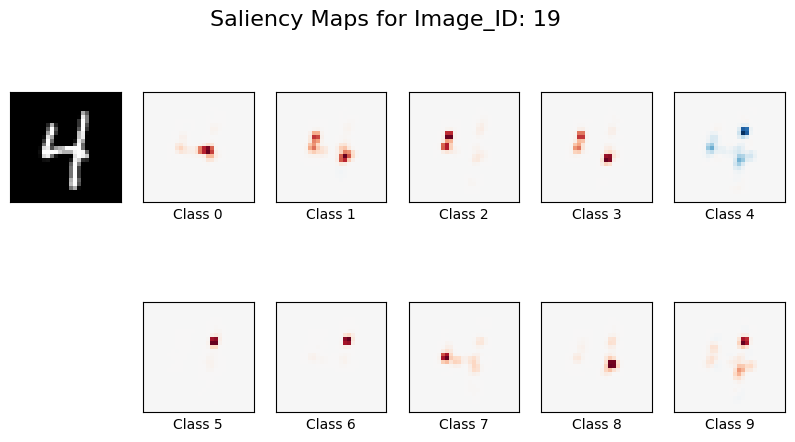

In [ ]:
class MLFlowQueryAndLogSaliency(MLFlowXAI):
    """
    A class that handles querying MLflow runs, setting and logging saliency parameters,
    and managing saliency map generation and storage within the MLflow framework.

    Inherits:
        MLFlowXAI: Base class for MLflow-based Explainable AI operations.
    """

    def __init__(self) -> None:
        """
        Initializes the MLFlowQueryAndLogSaliency class.
        Sets up the saliency run ID and an empty dictionary for saliency parameters.
        """
        super().__init__()
        self.saliency_run_id = None
        self.saliency_params = {}

    def query_run(
        self,
        filter_string: str,
        order_by: list[str],
        exp_id: str,
    ) -> mlflow.store.entities.paged_list.PagedList:  # type:ignore
        """
        Queries MLflow runs based on the given filters, ordering, and experiment ID.

        Args:
            filter_string (str): A filter string to query specific runs.
            order_by (list): A list specifying the order of the queried results.
            exp_id (list): List of experiment IDs to search within.

        Returns:
            DataFrame: A Pandas DataFrame containing the queried runs.
        """
        return mlflow.search_runs(
            experiment_ids=[exp_id],
            filter_string=filter_string,
            run_view_type=ViewType.ACTIVE_ONLY,
            order_by=order_by,
        )

    def set_saliency_params(self, saliency_params: dict[str, Any]) -> None:
        """
        Sets the saliency parameters to be used for generating saliency maps.

        Args:
            saliency_params (dict): A dictionary containing saliency-related parameters.
        """
        self.saliency_params = saliency_params

    def get_saliency_params(self) -> dict[str, Any]:
        """
        Retrieves the current saliency parameters.

        Returns:
            dict: The saliency parameters set in the instance.
        """
        return self.saliency_params

    def log_saliency_maps(
        self,
        experiment_name: str,
        conf_score: float,
        image_id: int,
        eval_exp_id: str,
        eval_run_id: str,
        sal_run_id: Optional[str] = None,
    ) -> Optional[str]:
        """
        Logs saliency maps and related metrics to MLflow.

        Args:
            experiment_name (str): Name of the MLflow experiment for saliency logging.
            conf_score (float): Confidence score of the predicted class for the image.
            image_id (int): ID of the image for which saliency maps are generated.
            eval_exp_id (str): Experiment ID of the evaluation experiment.
            eval_run_id (str): Run ID of the evaluation experiment.
            sal_run_id (str or None): Run ID of an existing saliency run (if modifying an existing run).

        Returns:
            str: The experiment ID of the saliency experiment.
        """
        experiment = self.init_experiment(experiment_name=experiment_name)

        sal_exp_id = experiment.experiment_id

        with mlflow.start_run(
            experiment_id=sal_exp_id,
            run_name=f"ImageID-{image_id}_saliency_maps",
            run_id=sal_run_id,
        ) as run:
            # Adding new tag to modified run
            if sal_run_id is not None:
                modified_run = {"Modified_run": "True"}
                mlflow.set_tags(modified_run)
                mlflow.set_tag("mlflow.runName", f"ImageID-{image_id}_saliency_maps")

            self.saliency_run_id = run.info.run_id

            mlflow.set_tags(experiment.tags)
            mlflow.set_tags(
                {
                    "Dataset": self.dataset,
                    "Datasplit": self.datasplit,
                    "Evaluation_exp_id": eval_exp_id,
                    "Evaluation_run_id": eval_run_id,
                },
            )

            s_map_path = "./saliency_map_np_arrays"
            if not os.path.exists(s_map_path):
                os.makedirs(s_map_path)

            mlflow.log_params(self.get_saliency_params())

            img_saliency, sal_maps = GenerateSaliency().gen_saliency_maps(
                image_id,
                X_test[image_id],
                image_classifier_mlp,
                gen_sliding_window,
            )

            np.save(os.path.join(s_map_path, "image_saliency_maps.npy"), sal_maps)
            mlflow.log_artifact(s_map_path)

            # Saliency maps saved under artifacts
            mlflow.log_figure(img_saliency, "Image_saliency_maps.png")

            mlflow.log_metric("Predicted_class_conf", conf_score)

            # Adding new metric and figure to modified run
            if sal_run_id is not None:
                mlflow.log_metric("Predicted_class_conf_new", conf_score)
                mlflow.log_figure(img_saliency, "Image_saliency_maps_new.png")
                return str(sal_exp_id)

        return sal_exp_id

    def get_saliency_run_id(self) -> Optional[str]:
        """
        Retrieves the run ID of the last logged saliency run.

        Returns:
            str or None: The run ID of the saliency run, or None if no run has been logged.
        """
        return self.saliency_run_id


# Filter and query based on top_class_confidence_score metric and Top_conf_class tag

conf_threshold = 0.9
top_class = 4
filter_string = (
    "metrics.Predicted_class_conf >= " + str(conf_threshold) + " and tags.Predicted_class = '" + str(top_class) + "'"
)

order = "DESC"  # or "ASC"
order_by = ["metrics.Predicted_class_conf " + order]

MLFlowQueryAndLogSaliency_obj = MLFlowQueryAndLogSaliency()
queried_runs = MLFlowQueryAndLogSaliency_obj.query_run(
    filter_string=filter_string,
    order_by=order_by,
    exp_id=eval_exp_id,
)

# Generate and log saliency maps for the top queried image id from the Evaluation stage.

top_conf_score = queried_runs["metrics.Predicted_class_conf"][0]
top_conf_score_img_id = int(queried_runs["tags.Image_id"][0])
top_conf_score_run_id = str(queried_runs["run_id"][0])

saliency_params = gen_sliding_window.get_config()

MLFlowQueryAndLogSaliency_obj.set_saliency_params(saliency_params)

sal_exp_id = MLFlowQueryAndLogSaliency_obj.log_saliency_maps(
    "MLPClassifier - Saliency Map Generation",
    top_conf_score,
    top_conf_score_img_id,
    eval_exp_id,
    top_conf_score_run_id,
    None,
)

## Reproduce Saliency Map results by querying existing run <a name="ReproduceSaliencyMaps-mlp-mnist"></a>

Using the ``saliency_run_id`` of an existing Saliency Generation run, we can query the Saliency Algorithm parameters and reproduce the same results as part of a new MLFlow run.

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Predicted_class_conf,params.stride,params.window_size,params.threads,...,tags.Datasplit,tags.mlflow.source.type,tags.mlflow.source.name,tags.Evaluation_run_id,tags.mlflow.runName,tags.mlflow.user,tags.Evaluation_exp_id,tags.framework,tags.Experiment,tags.Dataset
0,a0f4da6ee1be4aa5a3469f23ae0604d3,929669523538117905,FINISHED,file:///home/local/KHQ/alexander.lynch/Project...,2024-12-23 18:59:45.511000+00:00,2024-12-23 18:59:45.787000+00:00,1.0,"[1, 1]","[2, 2]",4,...,test,LOCAL,/home/local/KHQ/alexander.lynch/anaconda3/envs...,01f33ef7c29c42508927f8177e58ec6c,ImageID-19_saliency_maps,alexander.lynch,945703340747980714,sklearn,MLPClassifier - Saliency Map Generation,MNIST


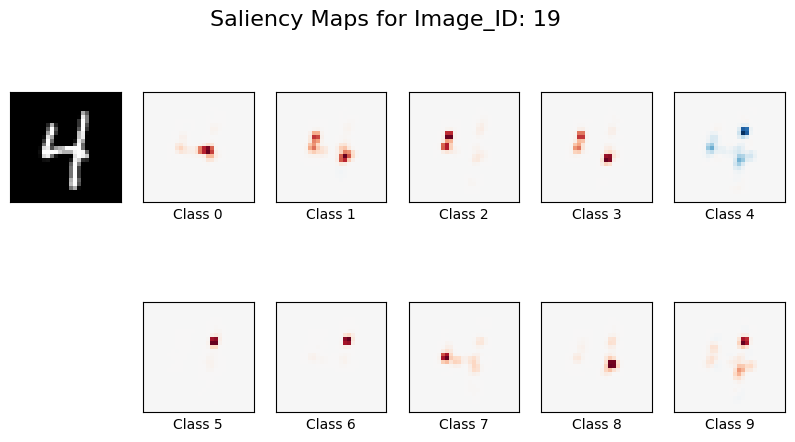

In [13]:
import ast

from IPython.display import display as ipython_display

filter_string = "tags.Evaluation_run_id = '" + top_conf_score_run_id + "'"
order = "DESC"  # or "ASC"
order_by = ["attribute.start_time " + order]

saliency_run_id = MLFlowQueryAndLogSaliency_obj.get_saliency_run_id()

# Querying Saliency parameters from an existing saliency generation run
queried_runs_saliency = MLFlowQueryAndLogSaliency_obj.query_run(
    filter_string=filter_string,
    order_by=order_by,
    exp_id=sal_exp_id,
)
ipython_display(queried_runs_saliency)

window_size = tuple(ast.literal_eval(queried_runs_saliency["params.window_size"][0]))
stride = tuple(ast.literal_eval(queried_runs_saliency["params.stride"][0]))
threads = int(queried_runs_saliency["params.threads"][0])

gen_sliding_window_rep_test = SlidingWindowStack(window_size=window_size, stride=stride, threads=threads)

img_saliency, sal_maps = GenerateSaliency().gen_saliency_maps(
    top_conf_score_img_id,
    X_test[top_conf_score_img_id],
    image_classifier_mlp,
    gen_sliding_window_rep_test,
)

## Edit existing Saliency Generation run <a name="MLFlowEditSaliency-mlp-mnist"></a>

We use the `get_saliency_run_id` method to return the MLFlow Run ID of an existing saliency generation run. Instead of creating a new run like the example cell above, we edit an existing run to generate and update the saliency maps for the queried ``Image_ID``.


Name: MLPClassifier - Saliency Map Generation
Experiment_id: 929669523538117905
Artifact Location: file:///home/local/KHQ/alexander.lynch/Projects/CDAO/xaitk-jatic/examples/mlflow/mlruns/929669523538117905
Tags: {'Experiment': 'MLPClassifier - Saliency Map Generation', 'framework': 'sklearn', 'version': 'v1'}
Lifecycle_stage: active


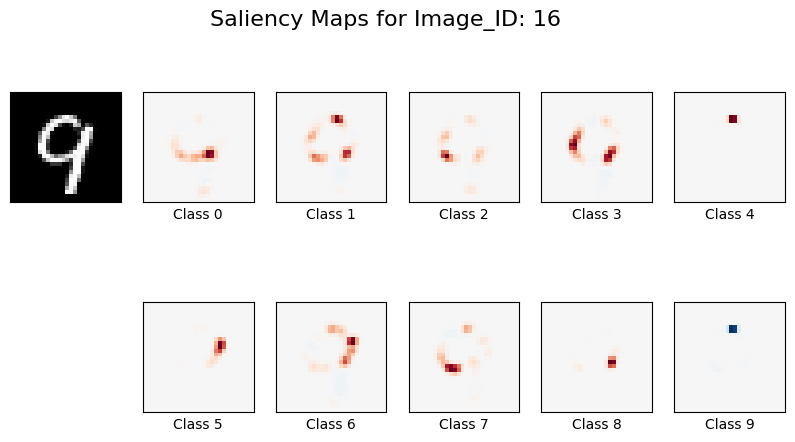

In [14]:
# Get Run ID of existing saliency generation run (in this case the most recent run)
existing_sal_run_id = MLFlowQueryAndLogSaliency_obj.get_saliency_run_id()

conf_threshold = 0.9
top_class = 9
filter_string = (
    "metrics.Predicted_class_conf >= " + str(conf_threshold) + " and tags.Predicted_class = '" + str(top_class) + "'"
)

order = "DESC"  # or "ASC"
order_by = ["metrics.Predicted_class_conf " + order]

queried_runs_new = MLFlowQueryAndLogSaliency_obj.query_run(
    filter_string=filter_string,
    order_by=order_by,
    exp_id=eval_exp_id,
)

top_conf_score_new = queried_runs_new["metrics.Predicted_class_conf"][0]
top_conf_score_img_id_new = int(queried_runs_new["tags.Image_id"][0])
top_conf_score_run_id_new = str(queried_runs_new["run_id"][0])

# Updated the existing run's tags, parameters and artifacts based on the new queried image
sal_exp_id = MLFlowQueryAndLogSaliency_obj.log_saliency_maps(
    "MLPClassifier - Saliency Map Generation",
    top_conf_score_new,
    top_conf_score_img_id_new,
    eval_exp_id,
    top_conf_score_run_id_new,
    existing_sal_run_id,
)

## Permanently delete existing MLFlow experiment <a name="MLFlowDeleteExperiment-mlp-mnist"></a>

While interacting with the MLFlow UI, the process of deleting an existing experiment does not permanently delete the contents of the experiment from the backend store. So, after deleting an experiment using the UI, it is important to run the following command from a terminal for permanent deletion:

> `mlflow gc`